In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 128
lr = 1e-4
z_dim = 128               # More noise dimension
image_dim = 28 * 28
num_classes = 10
embedding_dim = 10        # Smaller than z_dim to avoid overpowering
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator with label embedding, BatchNorm, Dropout
class Generator(nn.Module):
    def __init__(self, z_dim, image_dim, num_classes, embed_dim):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, embed_dim)
        self.gen = nn.Sequential(
            nn.Linear(z_dim + embed_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, image_dim),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.gen(x)

# Discriminator with label embedding
class Discriminator(nn.Module):
    def __init__(self, image_dim, num_classes, embed_dim):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, embed_dim)
        self.disc = nn.Sequential(
            nn.Linear(image_dim + embed_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([img, label_embedding], dim=1)
        return self.disc(x)

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model initialization
generator = Generator(z_dim, image_dim, num_classes, embedding_dim).to(device)
discriminator = Discriminator(image_dim, num_classes, embedding_dim).to(device)

# Optimizers and loss function
criterion = nn.BCELoss()
opt_gen = optim.Adam(generator.parameters(), lr=lr)
opt_disc = optim.Adam(discriminator.parameters(), lr=lr)

os.makedirs("out_cgan", exist_ok=True)

# Training loop
for epoch in range(num_epochs):
    for idx, (real, labels) in enumerate(dataloader):
        real = real.view(-1, image_dim).to(device)
        labels = labels.to(device)
        batch_size = real.size(0)

        real_targets = torch.full((batch_size, 1), 0.9, device=device)  # Label smoothing
        fake_targets = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(noise, labels)

        real_preds = discriminator(real, labels)
        fake_preds = discriminator(fake_images.detach(), labels)

        real_loss = criterion(real_preds, real_targets)
        fake_loss = criterion(fake_preds, fake_targets)
        d_loss = real_loss + fake_loss

        discriminator.zero_grad()
        d_loss.backward()
        opt_disc.step()

        # Train Generator twice
        for _ in range(2):
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z, labels)
            gen_preds = discriminator(fake_images, labels)
            g_loss = criterion(gen_preds, real_targets)

            generator.zero_grad()
            g_loss.backward()
            opt_gen.step()

        if idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(dataloader)} "
                  f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save sample images of digit 3 after each epoch
    generator.eval()
    with torch.no_grad():
        test_label = torch.full((16,), 3, dtype=torch.long).to(device)
        z = torch.randn(16, z_dim).to(device)
        samples = generator(z, test_label).view(-1, 1, 28, 28)
        grid = utils.make_grid(samples, nrow=4, normalize=True)
        utils.save_image(grid, f"out_cgan/epoch_{epoch}_digit3.png")
    generator.train()

print("Training complete.")


Epoch [0/50] Batch 0/469 D Loss: 1.3504 | G Loss: 0.7017
Epoch [0/50] Batch 100/469 D Loss: 0.9809 | G Loss: 0.9885
Epoch [0/50] Batch 200/469 D Loss: 0.6017 | G Loss: 2.3027
Epoch [0/50] Batch 300/469 D Loss: 1.1171 | G Loss: 0.9795
Epoch [0/50] Batch 400/469 D Loss: 1.3435 | G Loss: 0.9176
Epoch [1/50] Batch 0/469 D Loss: 1.0768 | G Loss: 1.2281
Epoch [1/50] Batch 100/469 D Loss: 0.9870 | G Loss: 1.2972
Epoch [1/50] Batch 200/469 D Loss: 0.9105 | G Loss: 1.3837
Epoch [1/50] Batch 300/469 D Loss: 1.0506 | G Loss: 1.2036
Epoch [1/50] Batch 400/469 D Loss: 1.4305 | G Loss: 0.9887
Epoch [2/50] Batch 0/469 D Loss: 1.3479 | G Loss: 1.3562
Epoch [2/50] Batch 100/469 D Loss: 1.0048 | G Loss: 1.4462
Epoch [2/50] Batch 200/469 D Loss: 1.0080 | G Loss: 1.1413
Epoch [2/50] Batch 300/469 D Loss: 1.2069 | G Loss: 0.9923
Epoch [2/50] Batch 400/469 D Loss: 1.1450 | G Loss: 1.0438
Epoch [3/50] Batch 0/469 D Loss: 1.2109 | G Loss: 1.1591
Epoch [3/50] Batch 100/469 D Loss: 1.1721 | G Loss: 1.1697
Epoch

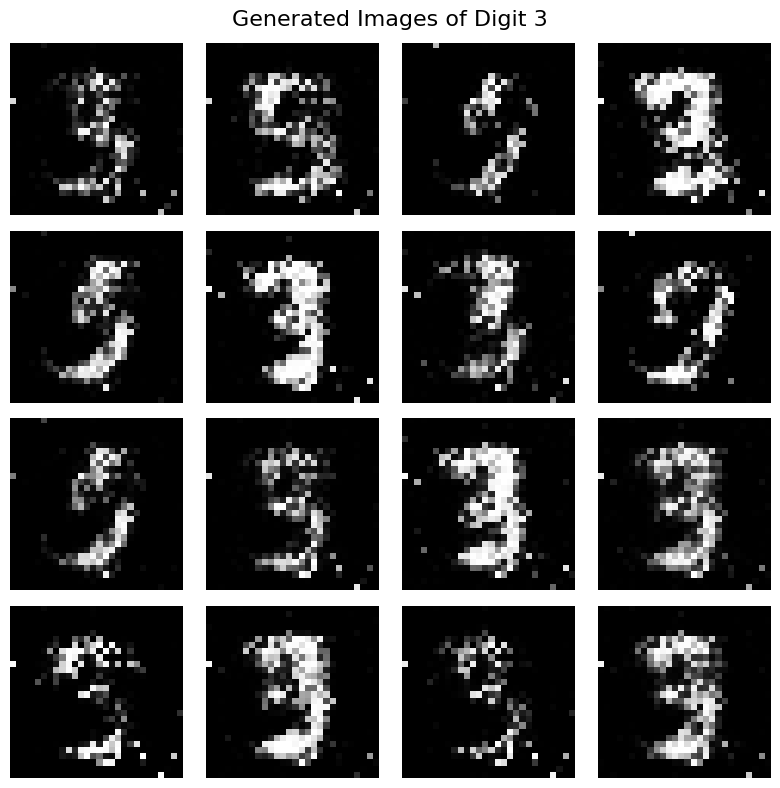

In [24]:
import matplotlib.pyplot as plt

# Set generator to evaluation mode
generator.eval()

with torch.no_grad():
    num_samples = 16
    condition_digit = 3  # Change this to generate another digit
    fixed_noise = torch.randn(num_samples, z_dim).to(device)
    fixed_labels = torch.full((num_samples,), condition_digit, dtype=torch.long).to(device)

    # Generate fake images
    fake_images = generator(fixed_noise, fixed_labels).view(-1, 1, 28, 28).cpu()

    # Plot the generated images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f"Generated Images of Digit {condition_digit}", fontsize=16)
    plt.tight_layout()
    plt.show()
